# Fairness in EDA

Reproduction of ProPublica related work

[1] ProPublica, “Machine Bias,” https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing, May 2016.

[2] A. Chouldechovaa. "Fair prediction with disparate impact: A study of bias in recidivism prediction instruments." arXiv preprint arXiv:1703.00056 (2017).

[3] F. P. Calmon, D. Wei, K. Natesan Ramamurthy, and K. R. Varshney, “Optimized Data Pre- Processing for Discrimination Prevention,” arXiv preprint arXiv:1704.03354 (2017)

I repeat the data filtering suggested by ProPublica:

- There are a number of reasons remove rows because of missing data:
- If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
- We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
- In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
- We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

The given features can be resolved as follows:
- age: defendant's age
- c_charge_degree: degree charged (Misdemeanor of Felony)
- race: defendant's race
- age_cat: defendant's age quantized in "less than 25", "25-45", or "over 45"
- score_text: COMPAS score: 'low'(1 to 5), 'medium' (5 to 7), and 'high' (8 to 10).
- sex: defendant's gender
- priors_count: number of prior charges
- days_b_screening_arrest: number of days between charge date and arrest where defendant was screened for compas score
- decile_score: COMPAS score from 1 to 10
- is_recid: if the defendant recidivized
- two_year_recid: if the defendant within two years
- c_jail_in: date defendant was imprisoned
- c_jail_out: date defendant was released from jail
- length_of_stay: length of jail stay


In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

%matplotlib inline
sns.set(font_scale=1.5)

In [2]:
df = pd.read_csv("https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv", header=0).set_index('id')

In [3]:
print(list(df))
print(df.head())
df = df[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
                    'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
df.head()

['name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event', 'two_year_recid']
                  name   first         last compas_screening_date   sex  \
id                                                                        
1     miguel hernandez  m

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
id,,,,,,,,,,,,,
1,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
3,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
4,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,23,F,African-American,Less than 25,High,Male,1,NaN,8,0,0,NaN,NaN
6,43,F,Other,25 - 45,Low,Male,2,NaN,1,0,0,NaN,NaN


In [4]:
# ix is the index of variables we want to keep.

# Remove entries with inconsistent arrest information.
ix = df['days_b_screening_arrest'] <= 30
ix = (df['days_b_screening_arrest'] >= -30) & ix

# remove entries entries where compas case could not be found.
ix = (df['is_recid'] != -1) & ix

# remove traffic offenses.
ix = (df['c_charge_degree'] != "O") & ix

# remove entries without available text scores.
ix = (df['score_text'] != 'N/A') & ix

# trim dataset
df = df.loc[ix,:]

# create new attribute "length of stay" with total jail time.
df['length_of_stay'] = (pd.to_datetime(df['c_jail_out'])-pd.to_datetime(df['c_jail_in'])).apply(lambda x: x.days)

# print number of rows
print('Number of rows : '+str(len(df)))
# print list of features again
print('Features: '+str(list(df)))

Number of rows : 6172
Features: ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out', 'length_of_stay']


For the scope of this analysis I over-simplify the world as black and white

In [5]:
df = df.loc[df['race'].isin(['African-American','Caucasian'])]
df['race'].value_counts()

African-American    3175
Caucasian           2103
Name: race, dtype: int64

In [6]:
table = df.groupby(['race','decile_score']).size().reset_index().pivot(index='decile_score',columns='race',values=0)
#table = df.groupby(['race','decile_score']).size()#.reset_index().pivot(index='decile_score',columns='race',values=0)

# percentage of defendants in each score category
#print(table.sum()) # yields total sum ... need to take the proper value counts
100*table/table.sum()

race,African-American,Caucasian
decile_score,,
1,11.496063,28.768426
2,10.897638,15.263909
3,9.385827,11.317166
4,10.614173,11.554922
5,10.173228,9.510223
6,10.015748,7.608179
7,10.803150,5.373276
8,9.480315,4.564907
9,9.984252,3.661436


In [8]:
table = df.groupby(['race','two_year_recid']).size().reset_index().pivot(index='two_year_recid',columns='race',values=0)
100*table/table.sum()

race,African-American,Caucasian
two_year_recid,,
0,47.685039,60.912981
1,52.314961,39.087019


In [10]:
table = df.groupby(['race','is_recid']).size().reset_index().pivot(index='is_recid',columns='race',values=0)
100*table/table.sum()

race,African-American,Caucasian
is_recid,,
0,44.15748,58.440323
1,55.84252,41.559677


Visualize it:

AttributeError: 'numpy.ndarray' object has no attribute 'count'

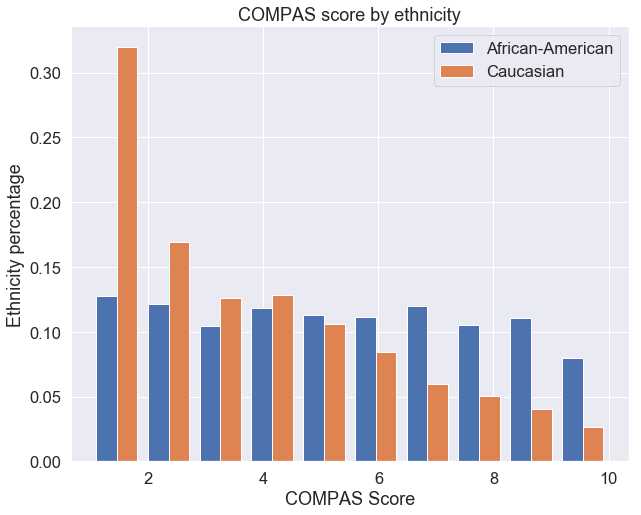

In [41]:
x = df.loc[df['race']=='African-American','decile_score'].values
y = df.loc[df['race']=='Caucasian','decile_score'].values
plt.figure(figsize=[10,8])
plt.hist([x,y],normed=True)
plt.legend(['African-American','Caucasian'])
plt.title('COMPAS score by ethnicity')
plt.xlabel('COMPAS Score')
plt.ylabel('Ethnicity percentage')

print(y.count())

# Error detected

This is extremely odd, the histogram does not match the table values!


# Quantization

In [42]:
dfQ = df.copy()

# Quantize priors count between 0, 1-3, and >3
def quantizePrior(x):
    if x <=0:
        return '0'
    elif 1<=x<=3:
        return '1 to 3'
    else:
        return 'More than 3'

    
# Quantize length of stay
def quantizeLOS(x):
    if x<= 7:
        return '<week'
    if 8<x<=93:
        return '<3months'
    else:
        return '>3 months'
    
# Quantize length of stay
def adjustAge(x):
    if x == '25 - 45':
        return '25 to 45'
    else:
        return x

# Quantize score_text to MediumHigh
def quantizeScore(x):
    if (x == 'High')| (x == 'Medium'):
        return 1
    else:
        return 0

    
dfQ['priors_count'] = dfQ['priors_count'].apply(quantizePrior)
dfQ['length_of_stay'] = dfQ['length_of_stay'].apply(quantizeLOS)
dfQ['score_text'] = dfQ['score_text'].apply(quantizeScore)
dfQ['age_cat'] = dfQ['age_cat'].apply(adjustAge)

# Compare difference of avg score by ethnicity

Text(0.5, 1.0, 'Average COMPAS score percentage difference between\nCaucasian and African-American for different groups')

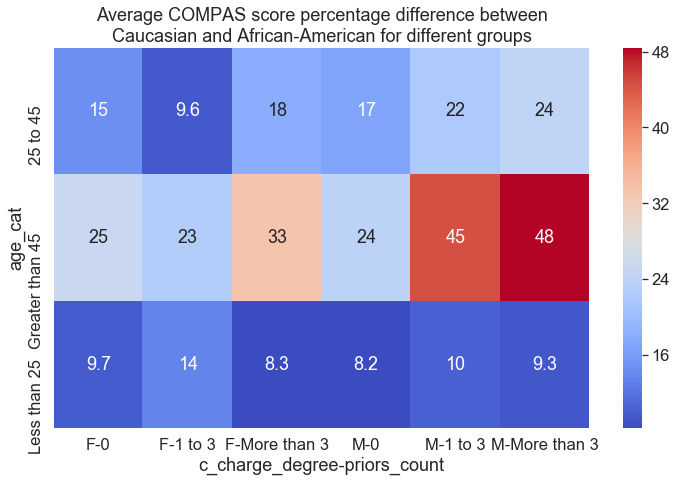

In [43]:
# African-american
dfPlot_AA = dfQ.loc[dfQ['race']=='African-American'].copy()
dfPlot_AA = dfPlot_AA.groupby(['age_cat','c_charge_degree','priors_count'])['decile_score'].mean().reset_index()
dfinal_AA = dfPlot_AA.pivot_table(index =['age_cat'],columns = ['c_charge_degree','priors_count'],values="decile_score")

# Caucasian
dfPlot_C = dfQ.loc[dfQ['race']=='Caucasian'].copy()
dfPlot_C = dfPlot_C.groupby(['age_cat','c_charge_degree','priors_count'])['decile_score'].mean().reset_index()
dfinal_C = dfPlot_C.pivot_table(index =['age_cat'],columns = ['c_charge_degree','priors_count'],values="decile_score")

plt.figure(figsize=[12,7])
sns.heatmap(100*(dfinal_AA.div(dfinal_C)-1),cmap="coolwarm",annot=True)
plt.title('Average COMPAS score percentage difference between\nCaucasian and African-American for different groups')

# Zoom in on interesting fields

Text(0, 0.5, 'Fraction of population')

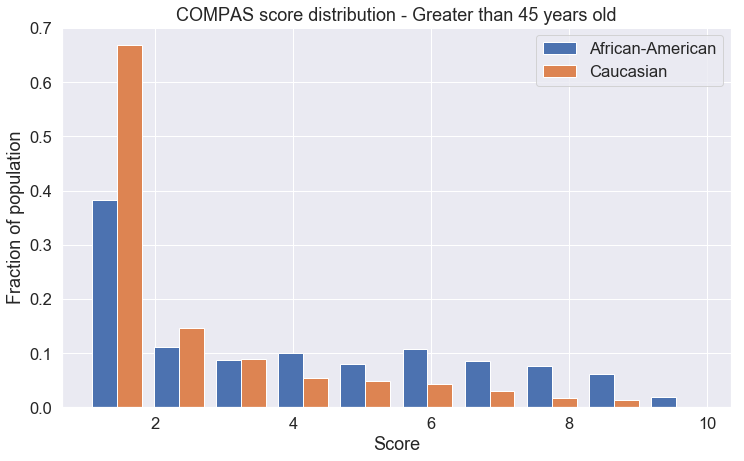

In [44]:
df_g45 = df.loc[(df['age']>=45)]
x = df_g45.loc[df_g45['race']=='African-American','decile_score'].values
y = df_g45.loc[df_g45['race']=='Caucasian','decile_score'].values
plt.figure(figsize=[12,7])
plt.hist([x,y],normed=True)
plt.legend(['African-American','Caucasian'])
plt.title('COMPAS score distribution - Greater than 45 years old')
plt.xlabel('Score')
plt.ylabel('Fraction of population')

# Error detected
This is calculated the same way so probably OFF

# 80:20 Rule

1. For COMPAS Score
2. For True-Recidivism

Difference is HUGE!

In [45]:
means = dfQ.groupby(['score_text','race']).size().unstack()
means = means/means.sum()
print(means)
# compute disparte impact
AA_with_high_score = means.loc[1,'African-American']
C_with_high_score = means.loc[1,'Caucasian']
percentage_diff = 100*(AA_with_high_score/C_with_high_score -1)
print('Percentage difference: %f%%' %percentage_diff)

race        African-American  Caucasian
score_text                             
0                   0.423937   0.669044
1                   0.576063   0.330956
Percentage difference: 74.060413%


In [46]:
means = dfQ.groupby(['two_year_recid','race']).size().unstack()
means = means/means.sum()
print(means)
# compute disparte impact
AA_with_high_score = means.loc[1,'African-American']
C_with_high_score = means.loc[1,'Caucasian']
percentage_diff = 100*(AA_with_high_score/C_with_high_score -1)
print(percentage_diff)

race            African-American  Caucasian
two_year_recid                             
0                        0.47685    0.60913
1                        0.52315    0.39087
33.842289786769356


# Calibration
For each the quantized score $s$ (low or high) I respectively look at the calibration for $s=1$.
The waekness of this measure is its dependency on the threshold on which we quantize the scores 𝑆𝑄

$$\mathsf{cal} \triangleq \frac{\mathbb{P}\left(Y=1\mid S_Q=s,R=\mbox{African-American} \right)}{\mathbb{P}\left(Y=1 \mid S_Q=s,R=\mbox{Caucasian} \right)},$$ 

$Y$ = true recidivism
$S_Q$ COMPAS score (0=low, 1=high medium)
$R$ race

In [47]:
# compute averages
dfAverage = dfQ.groupby(['race','score_text'])['two_year_recid'].mean().unstack()
print(dfAverage)

num = dfAverage.loc['African-American',1]
denom = dfAverage.loc['Caucasian',1]
cal = num/denom
calpercent = 100*(cal-1)
print('Calibration: %f' % cal)
print('Calibration in percentage: %f%%' % calpercent)

score_text               0         1
race                                
African-American  0.351412  0.649535
Caucasian         0.289979  0.594828
Calibration: 1.091972
Calibration in percentage: 9.197233%


# Predictive Parity

$$\mathsf{PP}(s) \triangleq \frac{\mathbb{P}\left(Y=1\mid S\geq s,R=\mbox{African-American} \right)}{\mathbb{P}\left(Y=1 \mid S\geq s,R=\mbox{Caucasian} \right)},$$
where $S$ is the original score.

Plotted for $s$ from 1 to 10. 

Text(0.5, 1.0, 'Predictive parity for different thresholds\n(warning: no error bars)')

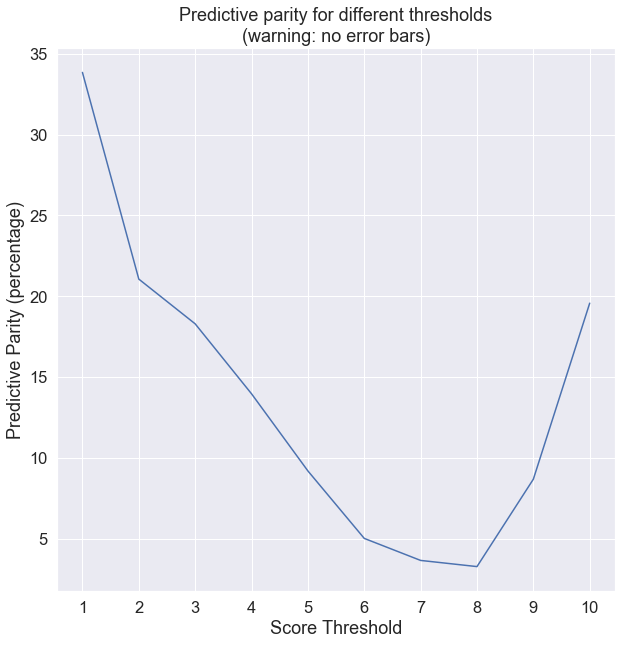

In [48]:
# aux function for thresh score
def threshScore(x,s):
    if x>=s:
        return 1
    else:
        return 0

ppv_values = []
dfP = dfQ[['race','two_year_recid']].copy()
for s in range(1,11):
    dfP['threshScore'] = dfQ['decile_score'].apply(lambda x: threshScore(x,s))
    dfAverage = dfP.groupby(['race','threshScore'])['two_year_recid'].mean().unstack()
    num = dfAverage.loc['African-American',1]
    denom = dfAverage.loc['Caucasian',1]
    ppv_values.append(100*(num/denom-1))


plt.figure(figsize=[10,10])
plt.plot(range(1,11),ppv_values)
plt.xticks(range(1,11))
plt.xlabel('Score Threshold')
plt.ylabel('Predictive Parity (percentage)')
plt.title('Predictive parity for different thresholds\n(warning: no error bars)')

# ROC

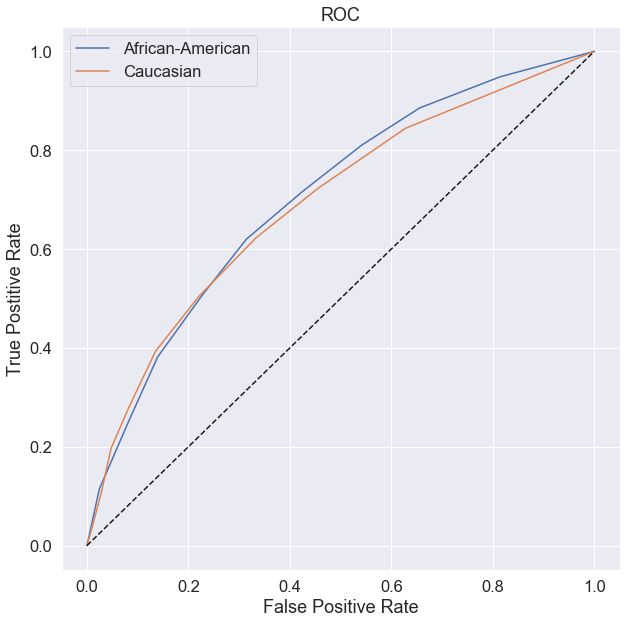

In [51]:
# normalize decile score
max_score = dfQ['decile_score'].max()
min_score = dfQ['decile_score'].min()
dfQ['norm_score'] = (dfQ['decile_score']-min_score)/(max_score-min_score)


plt.figure(figsize=[10,10])
#plot ROC curve for African-Americans
y = dfQ.loc[dfQ['race']=='African-American',['two_year_recid','norm_score']].values
fpr1,tpr1,thresh1 = roc_curve(y_true = y[:,0],y_score=y[:,1])
plt.plot(fpr1,tpr1)

#plot ROC curve for Caucasian
y = dfQ.loc[dfQ['race']=='Caucasian',['two_year_recid','norm_score']].values
fpr2,tpr2,thresh2 = roc_curve(y_true = y[:,0],y_score=y[:,1])
plt.plot(fpr2,tpr2)
l = np.linspace(0,1,10)
plt.plot(l,l,'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Postitive Rate')
plt.title('ROC')
plt.legend(['African-American','Caucasian'])

For each group, the point in the ROC curve corresponds to a $$(\mbox{false postive rate, true positive rate})$$ pair for a given threshold. In order to caputre the difference in error rates, we map the points to $$\left(\frac{\mbox{false postive rate Afr.-American}}{\mbox{false postive rate Cauc.}},s \right)$$
and similarly for *false negative* rates for different thersholds s.

Text(0.5, 1.0, 'Ratio between African-American and Caucasian error rates\n for different score thresholds')

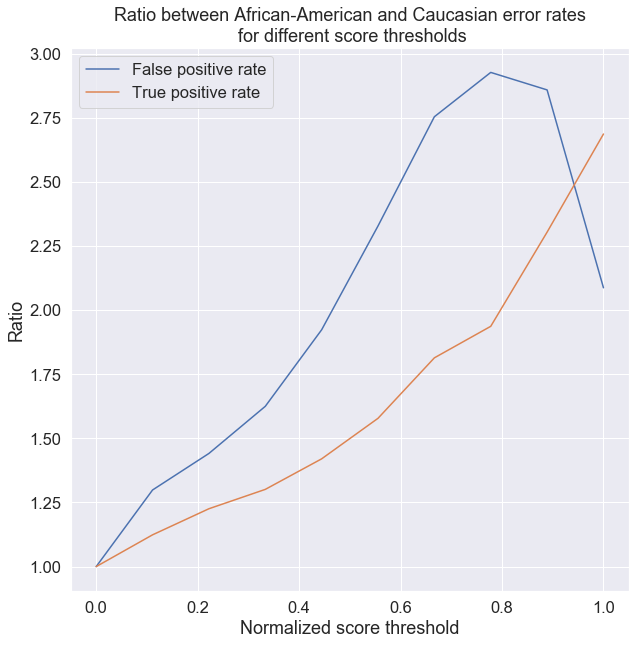

In [52]:
fpr_ratio = fpr1[1:]/fpr2[1:]
tpr_ratio = (tpr1[1:])/(tpr2[1:])
plt.figure(figsize=[10,10])
plt.plot(thresh1[1:],fpr_ratio)
plt.plot(thresh1[1:],tpr_ratio)
plt.xlabel('Normalized score threshold')
plt.ylabel('Ratio')

plt.legend(['False positive rate','True positive rate'])
plt.title('Ratio between African-American and Caucasian error rates\n for different score thresholds')